In [1]:
from pathlib import Path
import json, subprocess, requests
import polars as pl
import matplotlib.pyplot as plt
import glob

In [2]:
# Paths
PARQUET_DIR = Path("/home/vatereal/btc-node/parquet")   # your Parquet root
OUTPUT_DIR  = Path("/home/vatereal/Projects/BlockChain/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
assert PARQUET_DIR.exists(), f"Missing: {PARQUET_DIR}"

# RPC (HTTP first, fallback to docker exec bitcoin-cli)
RPC_URL  = "http://127.0.0.1:8332"
RPC_USER = "research"
RPC_PASS = "researchpass"

def _cid():
    try:
        return subprocess.check_output(
            ["bash","-lc","docker compose -f ~/btc-node/docker-compose.yml ps -q bitcoind"],
            text=True
        ).strip()
    except Exception:
        return ""

def rpc(method, params=None, timeout=10):
    try:
        r = requests.post(
            RPC_URL,
            json={"jsonrpc":"1.0","id":"nb","method":method,"params":params or []},
            auth=(RPC_USER, RPC_PASS), timeout=timeout
        )
        r.raise_for_status()
        j = r.json()
        if j.get("error"): raise RuntimeError(j["error"])
        return j["result"]
    except Exception as e_http:
        cid = _cid()
        if not cid:
            raise ConnectionError(f"RPC HTTP failed and container not found: {e_http}") from e_http
        cmd = ["docker","exec","-i",cid,"bitcoin-cli",
               "-rpcuser="+RPC_USER,"-rpcpassword="+RPC_PASS, method]
        for p in (params or []):
            cmd.append(json.dumps(p) if isinstance(p,(dict,list)) else str(p))
        out = subprocess.check_output(cmd, text=True).strip()
        try:
            return json.loads(out)
        except Exception:
            return out

# quick check
info = rpc("getblockchaininfo")
print("chain:", info["chain"], "| node height:", info["blocks"])
pl.Config.set_tbl_rows(20); pl.Config.set_fmt_str_lengths(80)

chain: main | node height: 315754


polars.config.Config

In [3]:

blocks_lf = pl.scan_parquet(str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"))
txs_lf    = pl.scan_parquet(str(PARQUET_DIR / "txs/day=*/txs-*.parquet"))
io_lf     = pl.scan_parquet(str(PARQUET_DIR / "io/day=*/io-*.parquet"))

ioe_glob = str(PARQUET_DIR / "io_enriched/day=*/ioen-*.parquet")
ioe_lf   = pl.scan_parquet(ioe_glob) if glob.glob(ioe_glob) else None

print("Scans ready.")


Scans ready.


In [4]:
def show_schema(lf, name):
    print(f"\n## {name} schema")
    for c, dt in lf.schema.items():
        print(f"  {c}: {dt}")

def quick_counts(lf, name):
    cols = lf.columns[:6]
    out = lf.select([pl.len().alias("rows")] + [pl.col(c).is_null().sum().alias(f"{c}__nulls") for c in cols])\
             .collect(streaming=True)
    display(out)

show_schema(blocks_lf, "blocks"); quick_counts(blocks_lf, "blocks")
show_schema(txs_lf, "txs"); quick_counts(txs_lf, "txs")
show_schema(io_lf, "io"); quick_counts(io_lf, "io")
if ioe_lf is not None:
    show_schema(ioe_lf, "io_enriched"); quick_counts(ioe_lf, "io_enriched")

print("blocks:"); display(blocks_lf.limit(5).collect(streaming=True))
print("txs:");    display(txs_lf.limit(5).collect(streaming=True))
print("io:");     display(io_lf.limit(5).collect(streaming=True))


## blocks schema
  height: Int64
  block_hash: String
  time: Datetime(time_unit='ns', time_zone=None)
  tx_count: Int64
  size: Int64
  weight: Int64


/tmp/ipykernel_10251/4175618393.py:3: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  for c, dt in lf.schema.items():
/tmp/ipykernel_10251/4175618393.py:7: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  cols = lf.columns[:6]
/tmp/ipykernel_10251/4175618393.py:9: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)


rows,height__nulls,block_hash__nulls,time__nulls,tx_count__nulls,size__nulls,weight__nulls
u32,u32,u32,u32,u32,u32,u32
119706,0,0,0,0,0,0



## txs schema
  height: Int64
  block_hash: String
  time: Datetime(time_unit='ns', time_zone=None)
  txid: String
  hash: String
  size: Int64
  vsize: Int64
  weight: Int64
  vin_count: Int64
  vout_count: Int64


rows,height__nulls,block_hash__nulls,time__nulls,txid__nulls,hash__nulls,size__nulls
u32,u32,u32,u32,u32,u32,u32
6002405,0,0,0,0,0,0



## io schema
  dir: String
  height: Int64
  time: Datetime(time_unit='ns', time_zone=None)
  txid: String
  n: Int64
  prev_txid: String
  prev_vout: Float64
  address: String
  value: Float64


rows,dir__nulls,height__nulls,time__nulls,txid__nulls,n__nulls,prev_txid__nulls
u32,u32,u32,u32,u32,u32,u32
25759855,0,0,0,0,0,13932021


blocks:


/tmp/ipykernel_10251/4175618393.py:18: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  print("blocks:"); display(blocks_lf.limit(5).collect(streaming=True))


height,block_hash,time,tx_count,size,weight
i64,str,datetime[ns],i64,i64,i64
74664,"""000000000030e5dedcc68f6dbaf398523c04de694b7feba595d70d668fdc1d79""",2010-08-16 04:39:02,1,215,860
74665,"""000000000015c363e380dd42bb3b16ef3f1dca2caf1446965afcffe8c08ea2df""",2010-08-16 04:48:08,1,217,868
74666,"""000000000026c2e655a9ac4cd19f3d5992ddf6530023b43fbfff0fa6ec7ac3f3""",2010-08-16 04:55:37,1,215,860
74667,"""000000000052801969753ac68206f9af9c92388844a2b485e7120258e6261f67""",2010-08-16 04:59:13,1,216,864
74668,"""000000000056fe2bde21392f6833151fb872389d73bf6f5ce67e7fc3d3450e6f""",2010-08-16 05:01:02,1,216,864


txs:


/tmp/ipykernel_10251/4175618393.py:19: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  print("txs:");    display(txs_lf.limit(5).collect(streaming=True))


height,block_hash,time,txid,hash,size,vsize,weight,vin_count,vout_count
i64,str,datetime[ns],str,str,i64,i64,i64,i64,i64
74664,"""000000000030e5dedcc68f6dbaf398523c04de694b7feba595d70d668fdc1d79""",2010-08-16 04:39:02,"""d6c7358b0286ca3f6cbf04d2b07c5c1b1bbb161be718c1f00392318ec0f20e17""","""d6c7358b0286ca3f6cbf04d2b07c5c1b1bbb161be718c1f00392318ec0f20e17""",134,134,536,1,1
74665,"""000000000015c363e380dd42bb3b16ef3f1dca2caf1446965afcffe8c08ea2df""",2010-08-16 04:48:08,"""a08c4112589351443d4fdf6b264bb95109e8dc5a269afc77ab9c08352be77418""","""a08c4112589351443d4fdf6b264bb95109e8dc5a269afc77ab9c08352be77418""",136,136,544,1,1
74666,"""000000000026c2e655a9ac4cd19f3d5992ddf6530023b43fbfff0fa6ec7ac3f3""",2010-08-16 04:55:37,"""c6708390f2c3680d4c74ef64aa5eb71a0fe011bde1066729edf31163649f2e94""","""c6708390f2c3680d4c74ef64aa5eb71a0fe011bde1066729edf31163649f2e94""",134,134,536,1,1
74667,"""000000000052801969753ac68206f9af9c92388844a2b485e7120258e6261f67""",2010-08-16 04:59:13,"""3df2f0d2eb40ecf5cf1084d05eaf9969458290724c19a6d3307df88be1560cdd""","""3df2f0d2eb40ecf5cf1084d05eaf9969458290724c19a6d3307df88be1560cdd""",135,135,540,1,1
74668,"""000000000056fe2bde21392f6833151fb872389d73bf6f5ce67e7fc3d3450e6f""",2010-08-16 05:01:02,"""9062c4065f912a23dd9027bc44ac719299786c97248ac88a8caa9a36a0758cbb""","""9062c4065f912a23dd9027bc44ac719299786c97248ac88a8caa9a36a0758cbb""",135,135,540,1,1


io:


/tmp/ipykernel_10251/4175618393.py:20: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  print("io:");     display(io_lf.limit(5).collect(streaming=True))


dir,height,time,txid,n,prev_txid,prev_vout,address,value
str,i64,datetime[ns],str,i64,str,f64,str,f64
"""in""",74664,2010-08-16 04:39:02,"""d6c7358b0286ca3f6cbf04d2b07c5c1b1bbb161be718c1f00392318ec0f20e17""",0,null,null,null,null
"""out""",74664,2010-08-16 04:39:02,"""d6c7358b0286ca3f6cbf04d2b07c5c1b1bbb161be718c1f00392318ec0f20e17""",0,null,null,null,50.0
"""in""",74665,2010-08-16 04:48:08,"""a08c4112589351443d4fdf6b264bb95109e8dc5a269afc77ab9c08352be77418""",0,null,null,null,null
"""out""",74665,2010-08-16 04:48:08,"""a08c4112589351443d4fdf6b264bb95109e8dc5a269afc77ab9c08352be77418""",0,null,null,null,50.0
"""in""",74666,2010-08-16 04:55:37,"""c6708390f2c3680d4c74ef64aa5eb71a0fe011bde1066729edf31163649f2e94""",0,null,null,null,null


/tmp/ipykernel_10251/857554921.py:5: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)
/tmp/ipykernel_10251/857554921.py:11: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)


day,blocks
date,u32
2012-08-08,166
2012-08-09,170
2012-08-10,156
2012-08-11,168
2012-08-12,159
2012-08-13,160
2012-08-14,157
2012-08-15,167
2012-08-16,154


day,txs
date,u32
2012-08-08,40168
2012-08-09,29942
2012-08-10,28375
2012-08-11,33139
2012-08-12,34636
2012-08-13,48872
2012-08-14,34506
2012-08-15,52969
2012-08-16,46477


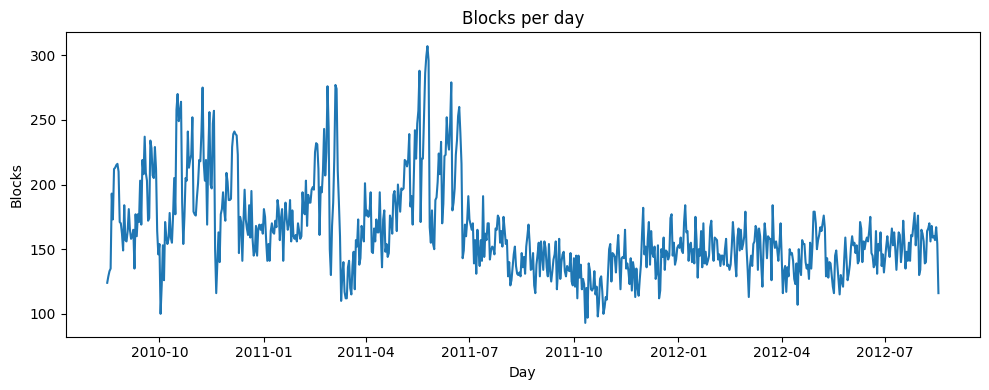

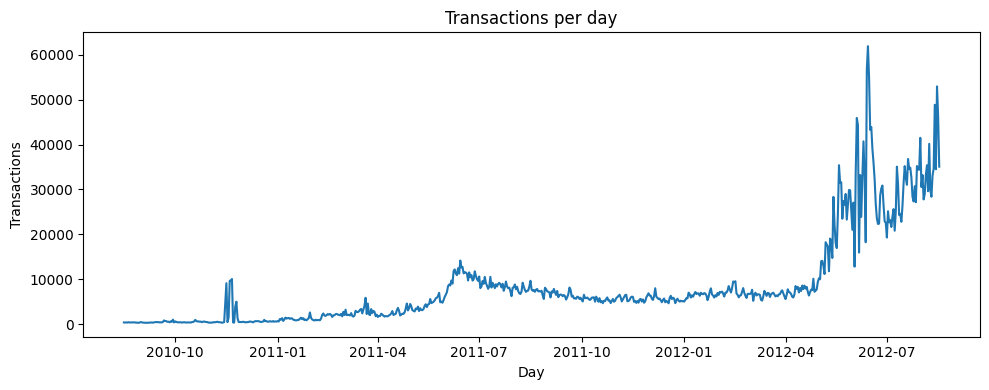

In [ ]:
blocks_daily = (
    blocks_lf.with_columns(pl.col("time").dt.date().alias("day"))
             .group_by("day").agg(pl.len().alias("blocks"))
             .sort("day")
).collect(streaming=True)

txs_daily = (
    txs_lf.with_columns(pl.col("time").dt.date().alias("day"))
          .group_by("day").agg(pl.len().alias("txs"))
          .sort("day")
).collect(streaming=True)

display(blocks_daily.tail(10))
display(txs_daily.tail(10))

plt.figure(figsize=(10,4))
plt.plot(blocks_daily["day"], blocks_daily["blocks"])
plt.title("Blocks per day"); plt.xlabel("Day"); plt.ylabel("Blocks"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(txs_daily["day"], txs_daily["txs"])
plt.title("Transactions per day"); plt.xlabel("Day"); plt.ylabel("Transactions"); plt.tight_layout(); plt.show()


In [ ]:
# Top addresses
if {"address","dir"} <= set(io_lf.columns):
    top_addrs = (
        io_lf.filter((pl.col("dir")=="out") & pl.col("address").is_not_null())
             .group_by("address").len()
             .sort("len", descending=True).limit(25)
    ).collect(streaming=True)
    display(top_addrs)
    top_addrs.write_csv(OUTPUT_DIR / "top_output_addresses.csv")

# Sum of output values per day
if "value" in io_lf.columns:
    out_value_daily = (
        io_lf.filter((pl.col("dir")=="out") & pl.col("value").is_not_null())
             .with_columns(pl.col("time").dt.date().alias("day"))
             .group_by("day").agg(pl.sum("value").alias("total_btc"))
             .sort("day")
    ).collect(streaming=True)
    display(out_value_daily.tail(10))
    out_value_daily.write_csv(OUTPUT_DIR / "outputs_value_daily.csv")

    plt.figure(figsize=(10,4))
    plt.plot(out_value_daily["day"], out_value_daily["total_btc"])
    plt.title("Sum of output values per day (BTC)")
    plt.xlabel("Day"); plt.ylabel("BTC"); plt.tight_layout(); plt.show()

/tmp/ipykernel_10251/965321894.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if {"address","dir"} <= set(io_lf.columns):
/tmp/ipykernel_10251/965321894.py:7: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  ).collect(streaming=True)


ShapeError: could not create a new DataFrame: series "len" has length 1 while series "address_nc" has length 0